<a href="https://colab.research.google.com/github/vvcastro/vvcastro-IIC3633-2020/blob/master/practicos/practico06_implicitFeedback.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctico librería implicit - ALS y BPR

Clase: IIC3633 Sistemas Recomendadores, PUC Chile

En este práctico vamos a utilizar la biblioteca de Python [implicit](https://implicit.readthedocs.io/en/latest/quickstart.html) para recomendación utilizando ALS y BPR. 


In [1]:
!curl -L -o "u2.base" "https://drive.google.com/uc?export=download&id=1bGweNw7NbOHoJz11v6ld7ymLR8MLvBsA"
!curl -L -o "u2.test" "https://drive.google.com/uc?export=download&id=1f_HwJWC_1HFzgAjKAWKwkuxgjkhkXrVg"
!curl -L -o "u.item" "https://drive.google.com/uc?export=download&id=10YLhxkO2-M_flQtyo9OYV4nT9IvSESuz"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    546      0 --:--:-- --:--:-- --:--:--   545
100 1546k  100 1546k    0     0  1584k      0 --:--:-- --:--:-- --:--:-- 1584k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    816      0 --:--:-- --:--:-- --:--:--   815
100  385k  100  385k    0     0   489k      0 --:--:-- --:--:-- --:--:--  489k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    815      0 --:--:-- --:--:-- --:--:--   813
100  230k  100  230k    0     0   297k      0 --:--:-- --:--:-- --:--:--  297k


In [2]:
!pip3 install implicit --upgrade

     |████████████████████████████████| 1.1MB 8.0MB/s 
  Created wheel for implicit: filename=implicit-0.4.4-cp36-cp36m-linux_x86_64.whl size=3419479 sha256=f85a570343eaa47d851e590375c0eb4098369cbe27f902a6f860af01895c5ff5
  Stored in directory: /root/.cache/pip/wheels/bf/d4/ec/fd4f622fcbefb7521f149905295b2c26adecb23af38aa28217
Successfully built implicit


In [3]:
import pandas as pd
import numpy as np
import implicit
import scipy.sparse as sparse

In [4]:
columns = ['movieid', 'title', 'release_date', 'video_release_date', \
           'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', \
           'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', \
           'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', \
           'Thriller', 'War', 'Western']

In [5]:
# Primero creamos el dataframe con los datos
df_train = pd.read_csv('u2.base',
                         sep='\t',
                         names=['userid', 'itemid', 'rating', 'timestamp'],
                         header=None)

# rating >= 3 , relevante (1) y rating menor a 3 es no relevante (0)
df_train.rating = [1 if x >=3 else 0 for x in df_train.rating ]

In [6]:
df_train.head()

,userid,itemid,rating,timestamp
0,1,3,1,878542960
1,1,4,1,876893119
2,1,5,1,889751712
3,1,6,1,887431973
4,1,7,1,875071561


In [7]:
# Cargamos el dataset con los items
df_items = pd.read_csv('u.item',
                        sep='|',
                        index_col=0,
                        names = columns,
                        header=None, 
                        encoding='latin-1')

In [8]:
df_items.head()

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [9]:
# Cargamos el dataset de testing
df_test = pd.read_csv('u2.test',
                      sep='\t',
                      names=['userid', 'itemid', 'rating', 'timestamp'],
                      header=None)


# rating >= 3 es relevante (1) y rating menor a 3 es no relevante (0) 
df_test.rating = [1 if x >=3 else 0 for x in df_test.rating ]


user_items_test = {}

for row in df_test.itertuples():
    if row[1] not in user_items_test:
        user_items_test[row[1]] = []
        
    user_items_test[row[1]].append(row[2])

In [10]:
df_test.head()

,userid,itemid,rating,timestamp
0,1,1,1,874965758
1,1,2,1,876893171
2,1,8,0,875072484
3,1,9,1,878543541
4,1,21,0,878542772


### Métricas

In [11]:
# Definicion de métricas (No editar)
# Obtenido de https://gist.github.com/bwhite/3726239

def precision_at_k(r, k):
    assert k >= 1
    r = np.asarray(r)[:k] != 0
    if r.size != k:
        raise ValueError('Relevance score length < k')
    return np.mean(r)

def average_precision(r):
    r = np.asarray(r) != 0
    out = [precision_at_k(r, k + 1) for k in range(r.size) if r[k]]
    if not out:
        return 0.
    return np.mean(out)

def mean_average_precision(rs):
    return np.mean([average_precision(r) for r in rs])
  
def dcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        return np.sum(np.subtract(np.power(2, r), 1) / np.log2(np.arange(2, r.size + 2)))
    return 0.


def ndcg_at_k(r, k):
    idcg = dcg_at_k(sorted(r, reverse=True), k)

    if not idcg:
        return 0.
    return dcg_at_k(r, k) / idcg

### Preprocesamiento de los datos a formato sparse

In [12]:
user_items = {}
itemset = set()

for row in df_train.itertuples():
    if row[1] not in user_items:
        user_items[row[1]] = []
        
    user_items[row[1]].append(row[2])
    itemset.add(row[2])

itemset = np.sort(list(itemset))

sparse_matrix = np.zeros((len(user_items), len(itemset)))

for i, items in enumerate(user_items.values()):
    sparse_matrix[i] = np.isin(itemset, items, assume_unique=True).astype(int)
    
matrix = sparse.csr_matrix(sparse_matrix.T)

user_ids = {key: i for i, key in enumerate(user_items.keys())}
user_item_matrix = matrix.T.tocsr()

In [13]:
def evaluate_model(model, n):
  mean_map = 0.
  mean_ndcg = 0.
  for u in user_items_test.keys():
    rec = [t[0] for t in model.recommend(u, user_item_matrix, n)]
    rel_vector = [np.isin(user_items_test[u], rec, assume_unique=True).astype(int)]
    mean_map += mean_average_precision(rel_vector)
    mean_ndcg += ndcg_at_k(rel_vector, n)

  mean_map /= len(user_items_test)
  mean_ndcg /= len(user_items_test)
  
  return mean_map, mean_ndcg

In [14]:
def show_recommendations(model, user, n):
  recommendations = [t[0] for t in model.recommend(user, user_item_matrix, n)]
  return df_items.loc[recommendations]['title']

In [15]:
def show_similar_movies(model, item, n=10):
  sim_items = [t[0] for t in model.similar_items(item, n)]
  return df_items.loc[sim_items]['title']

## ALS (Implicit Feedback)

**Pregunta 1:** Explique brevemente cómo funciona el algoritmo ALS.

**Respuesta:** Es una técnica asociada a matriz factorization que busca poder modelar la matriz de ratings a partir de dos matrices de aproximaciones $U$ y $V$, matrices latentes de usuarios e items. El termino _Least Squares_ es porque para hacer fit de estas matrices, se ocupa este algoritmo de optimización, pero, además, se deja constante uno de los vectores en cada iteración. Finalmente, en este caso estamos trabajando con implicit feedback y, por lo tanto mucho de las celdas no rellenas sí dan información.

In [16]:
# Definimos y entrenamos el modelo con optimización ALS
model_als = implicit.als.AlternatingLeastSquares(factors=100, iterations=10, use_gpu=False)
model_als.fit(matrix)

Ejemplo de recomendación y búsqueda de items similares con los factores latentes ya entrenados:

In [17]:
show_recommendations(model_als, user=77, n=10)

movieid
256    When the Cats Away (Chacun cherche son chat) (...
754                                    Red Corner (1997)
257                                  Men in Black (1997)
292                                      Rosewood (1997)
258                                       Contact (1997)
199                 Bridge on the River Kwai, The (1957)
248                           Grosse Pointe Blank (1997)
136                  Mr. Smith Goes to Washington (1939)
49                                           I.Q. (1994)
273                                          Heat (1995)
Name: title, dtype: object

In [18]:
maprec, ndcg = evaluate_model(model_als, n=10)
print('map: {}\nndcg: {}'.format(maprec, ndcg))

map: 0.061267539120749816
ndcg: 0.34150076569678406


**Pregunta 2:** Pruebe distintos valores para los parámetros de ALS y muestre gráficos de cómo se ven afectadas las métricas recién mostradas.

In [24]:
# Definimos y entrenamos el modelo con optimización ALS
latent_factors = [50, 100, 150, 200]
maprecs, ndcgs = [], []

for latent in latent_factors:
    model_als = implicit.als.AlternatingLeastSquares(factors=latent, iterations=30, use_gpu=False)
    model_als.fit(matrix)

    # evaluamos
    mapred, ndcg = evaluate_model(model_als, n=10)

    maprecs.append(mapred), ndcgs.append(ndcg)

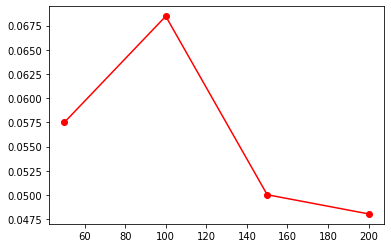

In [27]:
import matplotlib.pyplot as plt

plt.plot(latent_factors, maprecs, 'ro-')

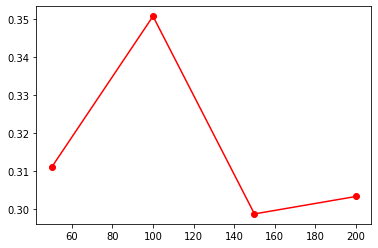

In [28]:
plt.plot(latent_factors, ndcgs, 'ro-')

## BPR

**Pregunta 3:** Explique con sus palabras la intuición del framework BPR.

**Respuesta:** Este framework cambia un poco la idea que se tenía hasta el momento, pues busca directamente solucionar el problema de generar una ranking list y no seguir la idea de mejor las predicciones y luego recomendar. Con este objetivo, en este sentido, se construye nuestro set de entrenamiento con pares de interacciones por usuario $(u, i, j)$ y, de esta forma, se quiere maximizar el número de predicciones correctas sobre estos pares.

In [29]:
# Definimos y entrenamos el modelo de implicit feedback utilizando optimizacion BPR
model_bpr = implicit.bpr.BayesianPersonalizedRanking(factors=400, iterations=40, use_gpu=False)
model_bpr.fit(matrix)

Ejemplo de recomendación y búsqueda de items similares con los factores latentes ya entrenados:

In [30]:
show_recommendations(model_bpr, user=77, n=10)

movieid
257                       Men in Black (1997)
285                     Secrets & Lies (1996)
332                     Kiss the Girls (1997)
299                            Hoodlum (1997)
327                           Cop Land (1997)
746                        Real Genius (1985)
244             Smilla's Sense of Snow (1997)
99     Snow White and the Seven Dwarfs (1937)
331                          Edge, The (1997)
676                      Crucible, The (1996)
Name: title, dtype: object

In [31]:
show_similar_movies(model_bpr, item=171, n=10)

movieid
171          Delicatessen (1991)
209    This Is Spinal Tap (1984)
27               Bad Boys (1995)
68              Crow, The (1994)
264                 Mimic (1997)
201          Evil Dead II (1987)
203            Unforgiven (1992)
194            Sting, The (1973)
175                Brazil (1985)
78             Free Willy (1993)
Name: title, dtype: object

In [22]:
maprec, ndcg = evaluate_model(model_bpr, n=10)
print('map: {}\nndcg: {}'.format(maprec, ndcg))

map: 0.04848023055957377
ndcg: 0.3782542113323124


**Pregunta 4:** Pruebe distintos valores para los parámetros de BPR y muestre gráficos de cómo se ven afectadas las métricas de ranking (nDCG@10 y MAP) recién mostradas.

In [35]:
# Definimos y entrenamos el modelo con optimización ALS
latent_factors = [300, 400, 500, 600]
maprecs, ndcgs = [], []

for latent in latent_factors:
    model_bpr = implicit.bpr.BayesianPersonalizedRanking(factors=latent, iterations=40, use_gpu=False)
    model_bpr.fit(matrix)

    # evaluamos
    mapred, ndcg = evaluate_model(model_bpr, n=10)

    maprecs.append(mapred), ndcgs.append(ndcg)

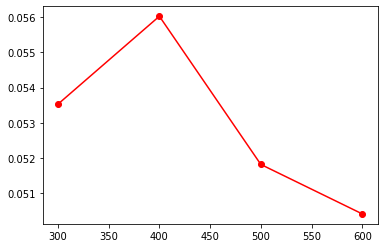

In [36]:
import matplotlib.pyplot as plt

plt.plot(latent_factors, maprecs, 'ro-')

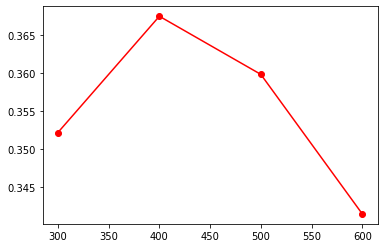

In [37]:
plt.plot(latent_factors, ndcgs, 'ro-')